# COMP90051 Project 2

In [39]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [40]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.arm=arm
        #N(A)=N(A)+1
        self.Nstep[self.arm]+=1
        #Q(A)=Q(A)+1/N(A)*[R-Q(A)] Q(A)=n-1/n*old value+1/n*new value
        self.Qreward[self.arm]=self.Qreward[self.arm]*(self.Nstep[self.arm]-1)/float(self.Nstep[self.arm])  
        +1/float(self.Nstep[self.arm])*reward

In [41]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms=narms
        self.epsilon=epsilon
        self.Q0=np.ones(self.narms)*np.inf#dimension:（narms,) array 
        #for n actions(each arm)Q=0,N=0
        self.Qreward=np.zeros(self.narms)
        self.Nstep=np.zeros(self.narms)
        return
        
        
    def play(self, tround, context=None):
        
        if np.random.random()<self.epsilon:
            action=np.random.choice(self.narms)#choose randomly [0,narms)
        else:
            if len(np.where(self.Q0==0)[0])<len(self.Q0):
                action = np.random.choice(np.where(self.Q0==max(self.Q0))[0])
                self.Q0[action]=0
            else:       
                action=np.random.choice(np.where(self.Qreward==max(self.Qreward))[0])#choose the max action [0,narms)
        
        return action+1
        
        
    def update(self, arm, reward, context=None):
        super(EpsGreedy,self).update(arm,reward,context)
        
        return 
    

In [62]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms=narms
        self.rho=rho
        self.Q0=np.ones(self.narms)*np.inf#array:1*narms(narms,)
        #for n actions(each arm)Q=0,N=0
        self.Qreward=np.zeros(self.narms)
        self.Q_Ucb_value=np.zeros(self.narms)#for choose the action
        self.Nstep=np.zeros(self.narms)
        #total count，this is equal to the tround
        self.total_step=0
        return
    
    def play(self, tround, context=None):
        self.total_step=tround
        if len(np.where(self.Q0==0)[0])<len(self.Q0):
                action = np.random.choice(np.where(self.Q0==max(self.Q0))[0])
                self.Q0[action]=0
        else:
            ucb_explore_value=np.zeros(self.narms)
            for action in range(self.narms):
                if self.Nstep[action]>0:
                    ucb_explore_value[action]=np.sqrt(self.rho*(np.log(self.total_step))/self.Nstep[action])
            
            self.Q_Ucb_value=self.Qreward+ucb_explore_value# add the ucb_explore_value
            action=np.random.choice(np.where(self.Q_Ucb_value==max(self.Q_Ucb_value))[0])
        return action+1
    def update(self, arm, reward, context=None):
        #self.total_step+=1
        super(UCB,self).update(arm,reward,context)
        return
    

## 2. The Basic Thompson Bandit

In [43]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        self.narms=narms
        self.Success=np.full(self.narms,alpha0)# initial alpha with alpha0
        self.Fail=np.full(self.narms,beta0)# initial beta with beta0
        self.theta = np.zeros(self.narms)
        
    def play(self, tround, context=None):
        narms=self.narms
        
        for i in range(narms):
            self.theta[i]=np.random.beta(self.Success[i],self.Fail[i])# use Beta(alpha,beta)
            
        action=np.random.choice(np.where(self.theta==max(self.theta))[0])#choose the max action [0,narms)
        
        return action+1
        
    def update(self, arm, reward, context=None):
        if reward==1:
            self.Success[arm]+=1
        else:
            self.Fail[arm]+=1
        

## 3. Off-Policy Evaluation

In [63]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    #history=[]
    reward_accumulated=np.zeros(nrounds)
    #initialize the round
    t=1
  
    for rows in range(np.shape(dataset)[0]):
        evaluate_action=mab.play(t,contexts[rows,:])
        current_action=arms[rows]
        if t<nrounds:
            if evaluate_action==current_action:
                #history.append(contexts[rows,:])
                reward_accumulated[t]+=rewards[rows]
                mab.update(evaluate_action-1,rewards[rows],contexts[rows,:])
                t+=1
        else:
            break
    return reward_accumulated

In [64]:
#load the data file and finish the init
dataset=np.loadtxt('./dataset.txt')
arms=dataset[:,0]
rewards=dataset[:,1]
contexts=dataset[:,2:102]
#print(np.shape(dataset)[0])

In [65]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.1075


In [66]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.195


In [33]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.22125


## 4. Contextual Bandits - LinUCB

In [34]:
class LinUCB(MAB): 
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms=narms
        self.ndims=ndims
        self.alpha=alpha
        self.Aa={}
        self.ba={}
        self.theta={}
        self.pta=np.zeros(self.ndims)#dimension: (d,)
        
        for each_arm in range(self.narms):
            self.Aa[each_arm]=np.identity(self.ndims)# dimension d*d
            self.ba[each_arm]=np.zeros((self.ndims,1))#dimension d*1
            self.theta[each_arm]=np.zeros((self.ndims,1))#dimension d*d.d*1=d*1
        return 
            
            
        
    def play(self, tround, context):
        for each_arm in range(self.narms):
            self.theta[each_arm]=np.dot(np.linalg.inv(self.Aa[each_arm]),self.ba[each_arm])#dimension:d*1 #check theta
            Xat=context[each_arm*10:(each_arm+1)*10]#dimension:1*d
            self.pta[each_arm]=np.dot(self.theta[each_arm].T,Xat)+self.alpha*np.sqrt(np.dot(np.dot(Xat.T,np.linalg.inv(self.Aa[each_arm])),Xat))
        action = np.random.choice(np.where(self.pta==max(self.pta))[0])
        return action+1
                                                                                
    def update(self, arm, reward, context):
        self.Aa[arm]+=np.outer(context[arm*10:(arm+1)*10],context[arm*10:(arm+1)*10])#outer can get a matrix not a constant
        self.ba[arm]+=reward*context[arm*10:(arm+1)*10].reshape(self.ndims,1)
        return 

In [35]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.52875


## 5. Contextual Bandits - LinThompson

In [36]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        self.narms=narms
        self.ndims=ndims
        self.v=v
        self.B=np.identity(ndims)#dimension d*d
        self.myou=np.zeros(ndims)#dimension (d,)
        self.f=np.zeros(ndims)   #dimension(d,)
        self.bmyou=np.zeros(ndims)#dimension: (d,) for choose the max
        
        return
    
    def play(self, tround, context):
        narms=self.narms
        
        self.myou=np.random.multivariate_normal(self.myou,np.dot(self.v*self.v,np.linalg.inv(self.B)))
      
        for i in range(self.narms):
            #context: 
            bi=context[i*10:(i+1)*10] 
            self.bmyou[i]=np.dot(bi,self.myou)
                                                          
        #choose the max action [0,narms)                                                  
        action = np.random.choice(np.where(self.bmyou==max(self.bmyou))[0])
        return action+1
            
    
    def update(self, arm, reward, context):
        self.B+=np.dot(context[arm*10:(arm+1)*10],context[arm*10:(arm+1)*10].T)
        self.f+=context[arm*10:(arm+1)*10]*reward
        self.myou=np.dot(np.linalg.inv(self.B),self.f) 
        return 

In [37]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.34125


## 6. Evaluation
### 6.A.

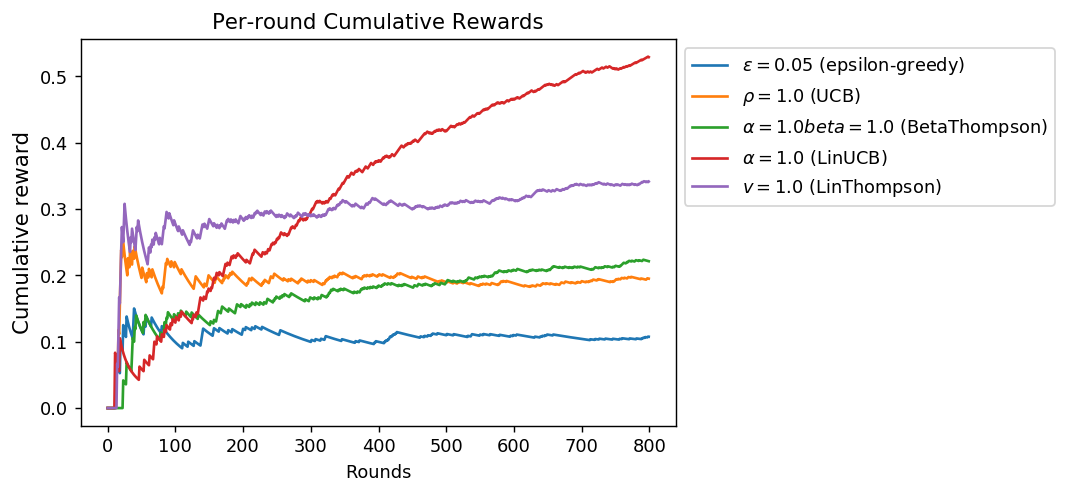

In [67]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

plt.plot(np.cumsum(results_EpsGreedy)/np.linspace(1,800,800),label = r"$\epsilon=0.05$ (epsilon-greedy)")
plt.plot(np.cumsum(results_UCB)/np.linspace(1,800,800),label = r"$\rho=1.0$ (UCB)")
plt.plot(np.cumsum(results_BetaThompson)/np.linspace(1,800,800),label = r"$\alpha=1.0 beta=1.0$ (BetaThompson)")
plt.plot(np.cumsum(results_LinUCB)/np.linspace(1,800,800),label = r"$\alpha=1.0$ (LinUCB)")
plt.plot(np.cumsum(results_LinThompson)/np.linspace(1,800,800),label = r"$v=1.0$ (LinThompson)")

plt.xlabel("Rounds")
plt.ylabel("Cumulative reward", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.legend(bbox_to_anchor=(1, 1))

### 6.B.

In [18]:
################################
#    test for alpha
################################
alpha_array=np.linspace(0,1,100)[1:]
alpha_reward_record=np.zeros(len(alpha_array))
#print(alpha_array)

for i in range(len(alpha_array)):
    mab=LinUCB(10,10,alpha_array[i])
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    alpha_reward_record[i]=np.mean(results_LinUCB)
print("The optimal value of alpha is: ",alpha_array[np.argmax(alpha_reward_record)])
print('The optimal LinUCB average reward', max(alpha_reward_record))

The optimal value of alpha is:  0.020202020202020204
The optimal LinUCB average reward 0.73125


In [19]:
print(alpha_reward_record)  #Monotonically decreasing

[0.73    0.73125 0.72125 0.71375 0.7275  0.7075  0.69875 0.7125  0.705
 0.7     0.69375 0.69625 0.69625 0.69125 0.7     0.68    0.67875 0.68625
 0.675   0.67375 0.67    0.64875 0.65625 0.6575  0.64375 0.64375 0.635
 0.6475  0.64    0.64375 0.6375  0.62375 0.625   0.62625 0.625   0.625
 0.63    0.63    0.63625 0.635   0.63625 0.64125 0.6325  0.63875 0.6325
 0.6275  0.6325  0.6375  0.62125 0.62875 0.625   0.625   0.6175  0.61625
 0.61625 0.6075  0.6     0.6     0.61    0.6075  0.59375 0.59375 0.5875
 0.585   0.58375 0.5775  0.57375 0.57625 0.575   0.5725  0.57875 0.56625
 0.565   0.57    0.565   0.5625  0.555   0.55875 0.55875 0.55875 0.54875
 0.55375 0.5575  0.5525  0.5425  0.54875 0.5475  0.5325  0.53125 0.545
 0.5425  0.54625 0.53875 0.54    0.53125 0.5325  0.5325  0.53    0.52875]


In [20]:
################################
#           test for v
################################
v_array=np.linspace(0,1,100)[1:]
v_reward_record=np.zeros(len(v_array))
#print(alpha_array)

for i in range(len(v_array)):
    mab = LinThompson(10, 10, v_array[i])
    results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
    v_reward_record[i]=np.mean(results_LinThompson)
print("The optimal value of v is: ",alpha_array[np.argmax(v_reward_record)])
print('The optimal LinThompson average reward', max(v_reward_record))

The optimal value of v is:  0.7373737373737375
The optimal LinThompson average reward 0.36875


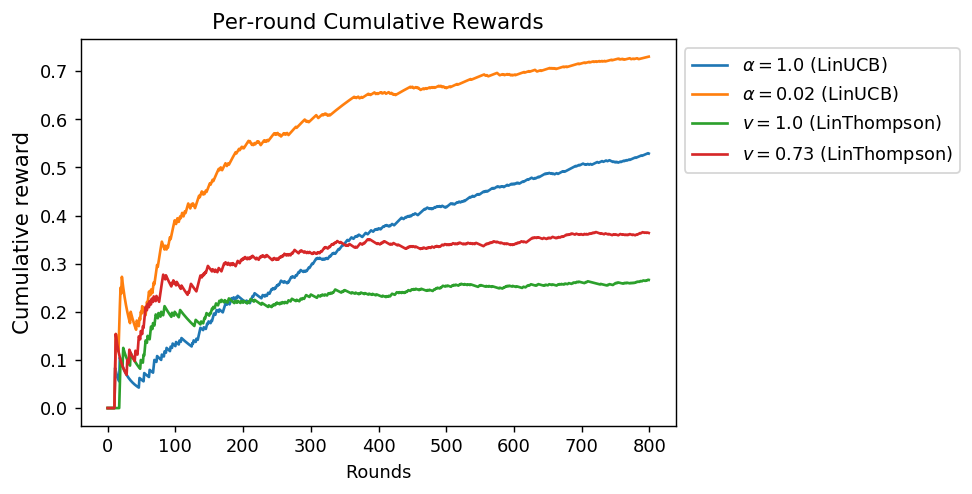

In [24]:
######################################
#   plot the results
######################################
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = LinUCB(10, 10, 0.02)
results_updated_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)

mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = LinThompson(10, 10, 0.73)
results_updated_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)

plt.plot(np.cumsum(results_LinUCB)/np.linspace(1,800,800),label = r"$\alpha=1.0$ (LinUCB)")
plt.plot(np.cumsum(results_updated_LinUCB)/np.linspace(1,800,800),label = r"$\alpha=0.02$ (LinUCB)")
plt.plot(np.cumsum(results_LinThompson)/np.linspace(1,800,800),label = r"$v=1.0$ (LinThompson)")
plt.plot(np.cumsum(results_updated_LinThompson)/np.linspace(1,800,800),label = r"$v=0.73$ (LinThompson)")

plt.xlabel("Rounds")
plt.ylabel("Cumulative reward", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.legend(bbox_to_anchor=(1, 1))